In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt
import tensorflow as tf
import yfinance as yf
import os
import mplfinance as mpf

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Dropout, LSTM, InputLayer

## 1) Load the dataset

In [2]:
# Ensure the necessary directories exist
DATA_DIR = "data"  # Directory to save the data
if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)
    
# Define constants outside the loop
COMPANY = 'CBA.AX'
DEFAULT_TRAIN_START = '2020-01-01'
DEFAULT_TRAIN_END = '2023-08-01'
while True:
    try:
        # Get training start date
        TRAIN_START = input(f"Enter training start date (YYYY-MM-DD) or press Enter for default '{DEFAULT_TRAIN_START}': ")
        if not TRAIN_START.strip():
            TRAIN_START = DEFAULT_TRAIN_START
        
        # Get training end date
        TRAIN_END = input(f"Enter training end date (YYYY-MM-DD) or press Enter for default '{DEFAULT_TRAIN_END}': ")
        if not TRAIN_END.strip():
            TRAIN_END = DEFAULT_TRAIN_END
        
        # Validate date format
        start_date = dt.datetime.strptime(TRAIN_START, '%Y-%m-%d')
        end_date = dt.datetime.strptime(TRAIN_END, '%Y-%m-%d')
        
        # Validate date range
        if start_date >= end_date:
            print("Error: Training end date must be after training start date.")
            continue
        
        print(f"Using training period: {TRAIN_START} to {TRAIN_END}")
        break  # Exit the loop if everything is valid
    
    except ValueError:
        print("Invalid date format. Please use YYYY-MM-DD format.")
        print(f"Using default values: {DEFAULT_TRAIN_START} to {DEFAULT_TRAIN_END}")
        TRAIN_START = DEFAULT_TRAIN_START
        TRAIN_END = DEFAULT_TRAIN_END
        break  # Or continue to ask again by removing this line

# Get the data for the stock AAPL
data = yf.download(COMPANY,TRAIN_START,TRAIN_END)
data_filename = f"{DATA_DIR}/{COMPANY}_data.csv"

# Check if the data file exists
if os.path.exists(data_filename):
    # If it exists, load the data from the file
    print(f"Loading data from {data_filename}")
    data = pd.read_csv(data_filename, index_col=0, parse_dates=True, date_format='%Y-%m-%d')
else:
    # If it does not exist, save the data to the file
    print(f"Saving data to {data_filename}")
    data.to_csv(data_filename)
    print(f"Data saved to {data_filename}")

Using training period: 2020-01-01 to 2025-01-01
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Saving data to data/CBA.AX_data.csv
Data saved to data/CBA.AX_data.csv


## 2) Clean and preprocess the data

In [3]:
df = pd.read_csv(data_filename, skiprows=[1,2])

# Preprocess the data
# The columns actually contain: Date, Price, Close, High, Low, Volume
df.columns = ['Date', 'Price', 'Close', 'High', 'Low', 'Volume']

# Convert the 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Convert the financial data columns to numeric
numeric_columns = ['Price', 'Close', 'High', 'Low', 'Volume']
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    
# Save new cleaned data to a CSV file
cleaned_data_filename = f"{DATA_DIR}/{COMPANY}_cleaned_data.csv"
df.to_csv(cleaned_data_filename, index=False)
print(f"Cleaned data saved to {cleaned_data_filename}")

# Check few rows of the cleaned data
print("Cleaned Data Sample:")
print(df.head())


Cleaned data saved to data/CBA.AX_cleaned_data.csv
Cleaned Data Sample:
        Date      Price      Close       High        Low   Volume
0 2020-01-02  64.933319  65.209704  64.535007  64.860162  1416232
1 2020-01-03  65.282867  65.998211  65.234096  65.819375  1622784
2 2020-01-06  64.843910  64.933328  64.404957  64.811400  2129260
3 2020-01-07  66.006332  66.006332  65.177192  65.697438  2417468
4 2020-01-08  65.762459  66.046968  65.055246  66.022582  1719114


In [4]:
df = pd.read_csv(cleaned_data_filename)

def split_by_ratio_sequential(df, test_size_ratio):
    """Splits the data sequentially based on a ratio."""
    split_index = int(len(df) * (1 - test_size_ratio))
    train_data = df.iloc[:split_index]
    test_data = df.iloc[split_index:]
    return train_data, test_data

def split_by_date(df, cutoff_date):
    """Splits the data based on a specific cutoff date."""
    cutoff_date = pd.to_datetime(cutoff_date)
    train_data = df[df['Date'] < cutoff_date]
    test_data = df[df['Date'] >= cutoff_date]
    return train_data, test_data

def split_by_ratio_random(df, test_size_ratio):
    """Splits the data randomly based on a ratio."""
    train_data, test_data = train_test_split(df, test_size=test_size_ratio, random_state=42, shuffle=True)
    return train_data, test_data

while True:
    print("\nChoose a data splitting method:")
    print("1. Sequential split by ratio")
    print("2. Split by date")
    print("3. Random split by ratio")
    choice = input("Enter your choice (1/2/3): ")
    
    if choice == '1':
        ratio = float(input("Enter the test size ratio (e.g., 0.2 for 20%): "))
        test_ratio = ratio if 0 < ratio < 1 else 0.2
        train_data, test_data = split_by_ratio_sequential(df, test_ratio)
        print(f"Data split sequentially with {test_ratio*100}% for testing.")
        break
    elif choice == '2':
        cutoff_date = input("Enter the cutoff date (YYYY-MM-DD): ")
        train_data, test_data = split_by_date(df, cutoff_date)
        print(f"Data split by date with cutoff at {cutoff_date}.")
        break
    elif choice == '3':
        ratio = float(input("Enter the test size ratio (e.g., 0.2 for 20%): "))
        test_ratio = ratio if 0 < ratio < 1 else 0.2
        train_data, test_data = split_by_ratio_random(df, test_ratio)
        print(f"Data split randomly with {test_ratio*100}% for testing.")
        break
    else:
        print("Invalid choice. Please enter 1, 2, or 3.")
        
# Print the shapes of the train and test datasets
print(f"Train data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")


Choose a data splitting method:
1. Sequential split by ratio
2. Split by date
3. Random split by ratio
Data split sequentially with 30.0% for testing.
Train data shape: (886, 6)
Test data shape: (380, 6)


In [5]:
# Scale the feature columns and store scalers
from sklearn.preprocessing import MinMaxScaler
import pickle

# Define the feature columns to scale (excluding Date if it's a column)
feature_columns = ['Close', 'High', 'Low', 'Open', 'Volume']

# Dictionary to store scalers for each feature
scalers = {}
scaled_train_data = train_data.copy()
scaled_test_data = test_data.copy()

print("Scaling feature columns...")
for column in feature_columns:
    if column in train_data.columns:
        # Create a separate scaler for each feature
        scaler = MinMaxScaler(feature_range=(0, 1))
        
        # Fit the scaler on training data only
        scaled_train_data[column] = scaler.fit_transform(train_data[[column]])
        
        # Transform test data using the same scaler
        scaled_test_data[column] = scaler.transform(test_data[[column]])
        
        # Store the scaler in the dictionary
        scalers[column] = scaler
        
        print(f"Scaled column: {column}")
        print(f"  Original range: [{train_data[column].min():.4f}, {train_data[column].max():.4f}]")
        print(f"  Scaled range: [{scaled_train_data[column].min():.4f}, {scaled_train_data[column].max():.4f}]")

# Save scalers to file for future use
scalers_filename = f"{DATA_DIR}/{COMPANY}_scalers.pkl"
with open(scalers_filename, 'wb') as f:
    pickle.dump(scalers, f)
print(f"\nScalers saved to {scalers_filename}")

# Display scaling summary
print(f"\nScaling Summary:")
print(f"Number of features scaled: {len(scalers)}")
print(f"Scaled features: {list(scalers.keys())}")
print(f"Train data shape after scaling: {scaled_train_data.shape}")
print(f"Test data shape after scaling: {scaled_test_data.shape}")

# Function to load scalers from file
def load_scalers(filename):
    """Load scalers from pickle file"""
    try:
        with open(filename, 'rb') as f:
            return pickle.load(f)
    except FileNotFoundError:
        print(f"Scalers file {filename} not found!")
        return None

# Function to inverse transform scaled data
def inverse_transform_predictions(scaled_predictions, column_name, scalers_dict):
    """Inverse transform scaled predictions back to original scale"""
    if column_name in scalers_dict:
        scaler = scalers_dict[column_name]
        return scaler.inverse_transform(scaled_predictions.reshape(-1, 1)).flatten()
    else:
        print(f"Scaler for column '{column_name}' not found!")
        return scaled_predictions

# Example usage of loading scalers (for future sessions)
# loaded_scalers = load_scalers(scalers_filename)
# if loaded_scalers:
#     print("Scalers loaded successfully!")

# Display sample of scaled data
print("\nSample of scaled training data:")
print(scaled_train_data.head())

print("\nSample of scaled test data:")
print(scaled_test_data.head())

Scaling feature columns...
Scaled column: Close
  Original range: [48.0495, 101.3394]
  Scaled range: [0.0000, 1.0000]
Scaled column: High
  Original range: [44.4250, 100.3935]
  Scaled range: [0.0000, 1.0000]
Scaled column: Low
  Original range: [46.5615, 101.1302]
  Scaled range: [0.0000, 1.0000]
Scaled column: Volume
  Original range: [350619.0000, 17021972.0000]
  Scaled range: [0.0000, 1.0000]

Scalers saved to data/CBA.AX_scalers.pkl

Scaling Summary:
Number of features scaled: 4
Scaled features: ['Close', 'High', 'Low', 'Volume']
Train data shape after scaling: (886, 6)
Test data shape after scaling: (380, 6)

Sample of scaled training data:
         Date      Price     Close      High       Low    Volume
0  2020-01-02  64.933319  0.322016  0.359309  0.335333  0.063919
1  2020-01-03  65.282867  0.336813  0.371800  0.352911  0.076308
2  2020-01-06  64.843910  0.316830  0.356986  0.334440  0.106688
3  2020-01-07  66.006332  0.336965  0.370783  0.350677  0.123976
4  2020-01-08  65.

In [6]:
# Number of days to look back to base the prediction
PREDICTION_DAYS = 60 # Original

# Function to create the dataset with lookback
def create_dataset(data, look_back=1):
    """Create dataset with lookback feature"""
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), :])
        y.append(data[i + look_back, 0])  # Assuming the first column is the target
    return np.array(X), np.array(y)

# 4) Build the model

In [7]:
#------------------------------------------------------------------------------
# Build the Model
## Enhanced with:
# 1) Check if data has been built before. If so, load the saved data
# 2) Check if model has been trained before. If so, load the saved model
# 3) Use multiple features for better accuracy
# 4) Model saving and loading functionality
#------------------------------------------------------------------------------

# Define file paths for saving/loading
MODEL_DIR = "models"
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

model_filename = f"{MODEL_DIR}/{COMPANY}_lstm_model.h5"
training_data_filename = f"{DATA_DIR}/{COMPANY}_training_data.npz"

# Prepare the training data using multiple features
print("Preparing training sequences...")

# Select features for training (exclude Date column)
available_features = [col for col in ['Close', 'High', 'Low', 'Price', 'Volume'] if col in scaled_train_data.columns]
print(f"Available features: {available_features}")

# Check if training data has been built before
if os.path.exists(training_data_filename):
    print(f"Loading pre-built training data from {training_data_filename}")
    training_data = np.load(training_data_filename)
    X_train = training_data['X_train']
    y_train = training_data['y_train']
    X_test = training_data['X_test']
    y_test = training_data['y_test']
    num_features = training_data['num_features']
    print(f"Loaded training data - X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
else:
    print("Building training sequences from scratch...")
    
    # Prepare feature data
    train_feature_data = scaled_train_data[available_features].values
    test_feature_data = scaled_test_data[available_features].values
    
    # Create sequences using the enhanced function
    X_train, y_train = create_dataset(train_feature_data, look_back=PREDICTION_DAYS)
    X_test, y_test = create_dataset(test_feature_data, look_back=PREDICTION_DAYS)
    
    num_features = len(available_features)
    
    print(f"Training sequences created:")
    print(f"  X_train shape: {X_train.shape}")
    print(f"  y_train shape: {y_train.shape}")
    print(f"  X_test shape: {X_test.shape}")
    print(f"  y_test shape: {y_test.shape}")
    print(f"  Number of features: {num_features}")
    
    # Save the training data
    np.savez(training_data_filename,
             X_train=X_train, y_train=y_train,
             X_test=X_test, y_test=y_test,
             num_features=num_features)
    print(f"Training data saved to {training_data_filename}")

# Check if model has been trained before
if os.path.exists(model_filename):
    print(f"Loading pre-trained model from {model_filename}")
    model = tf.keras.models.load_model(model_filename)
    print("Model loaded successfully!")
    print(model.summary())
else:
    print("Building and training new model...")
    
    # Build the enhanced model
    model = Sequential()
    
    # First LSTM layer with multiple features input
    model.add(LSTM(units=50, return_sequences=True, input_shape=(PREDICTION_DAYS, num_features)))
    model.add(Dropout(0.2))
    
    # Second LSTM layer
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))
    
    # Third LSTM layer
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    
    # Output layer
    model.add(Dense(units=1))
    
    # Compile the model with enhanced settings
    model.compile(
        optimizer='adam',
        loss='mean_squared_error',
        metrics=['mae', 'mse']  # Additional metrics for monitoring
    )
    
    print("Model architecture:")
    model.summary()
    
    # Train the model with enhanced parameters
    print("Training the model...")
    history = model.fit(
        X_train, y_train,
        epochs=25,
        batch_size=32,
        validation_data=(X_test, y_test),  # Monitor validation performance
        verbose=1,
        shuffle=False  # Important for time series data
    )
    
    # Save the trained model
    model.save(model_filename)
    print(f"Model saved to {model_filename}")
    
    # Save training history
    history_filename = f"{MODEL_DIR}/{COMPANY}_training_history.npz"
    np.savez(history_filename,
             loss=history.history['loss'],
             val_loss=history.history['val_loss'],
             mae=history.history['mae'],
             val_mae=history.history['val_mae'])
    print(f"Training history saved to {history_filename}")

# Function to load a pre-trained model
def load_pretrained_model(model_path):
    """Load a pre-trained model from file"""
    try:
        model = tf.keras.models.load_model(model_path)
        print(f"Model loaded successfully from {model_path}")
        return model
    except Exception as e:
        print(f"Error loading model: {e}")
        return None

# Function to save current model
def save_current_model(model, model_path):
    """Save the current model to file"""
    try:
        model.save(model_path)
        print(f"Model saved successfully to {model_path}")
        return True
    except Exception as e:
        print(f"Error saving model: {e}")
        return False

# Display model performance summary
print("\n" + "="*50)
print("MODEL SUMMARY")
print("="*50)
print(f"Model file: {model_filename}")
print(f"Training data shape: {X_train.shape}")
print(f"Features used: {available_features}")
print(f"Prediction days: {PREDICTION_DAYS}")
print(f"Total parameters: {model.count_params():,}")

# Evaluate the model on test data
print("\nEvaluating model on test data...")
test_loss, test_mae, test_mse = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss (MSE): {test_loss:.6f}")
print(f"Test MAE: {test_mae:.6f}")
print(f"Test RMSE: {np.sqrt(test_mse):.6f}")

# Calculate accuracy percentage
test_predictions = model.predict(X_test)
# Convert back to original scale for meaningful accuracy calculation
original_predictions = inverse_transform_predictions(test_predictions, 'Close', scalers)
original_actual = inverse_transform_predictions(y_test.reshape(-1, 1), 'Close', scalers)

# Calculate percentage accuracy
percentage_errors = np.abs((original_actual - original_predictions) / original_actual) * 100
mean_percentage_error = np.mean(percentage_errors)
accuracy_percentage = 100 - mean_percentage_error

print(f"\nPrediction Accuracy: {accuracy_percentage:.2f}%")
print(f"Mean Percentage Error: {mean_percentage_error:.2f}%")
print("="*50)

Preparing training sequences...
Available features: ['Close', 'High', 'Low', 'Price', 'Volume']
Building training sequences from scratch...
Training sequences created:
  X_train shape: (826, 60, 5)
  y_train shape: (826,)
  X_test shape: (320, 60, 5)
  y_test shape: (320,)
  Number of features: 5
Training data saved to data/CBA.AX_training_data.npz
Building and training new model...
Model architecture:


C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        11,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,651 (201.76 KB)

 Trainable params: 51,651 (201.76 KB)

 Non-trainable params: 0 (0.00 B)

Training the model...
Epoch 1/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 0.0412 - mae: 0.1733 - mse: 0.0412 - val_loss: 0.4750 - val_mae: 0.5980 - val_mse: 0.4750
Epoch 2/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.1990 - mae: 0.3963 - mse: 0.1990 - val_loss: 0.2250 - val_mae: 0.3749 - val_mse: 0.2250
Epoch 3/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.3254 - mae: 0.4933 - mse: 0.3254 - val_loss: 0.3579 - val_mae: 0.4948 - val_mse: 0.3579
Epoch 4/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.2435 - mae: 0.4330 - mse: 0.2435 - val_loss: 0.5490 - val_mae: 0.6599 - val_mse: 0.5490
Epoch 5/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.1360 - mae: 0.3230 - mse: 0.1360 - val_loss: 0.2929 - val_mae: 0.4364 - val_mse: 0.2929
Epoch 6/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.1449 - mae: 0.3169 - mse: 0.1449 - val_loss: 0.3182 - val_mae: 0.4615 - val_mse: 0.3182
Epoch 7/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0333 - mae: 0.1519 - ms

Model saved to models/CBA.AX_lstm_model.h5
Training history saved to models/CBA.AX_training_history.npz

MODEL SUMMARY
Model file: models/CBA.AX_lstm_model.h5
Training data shape: (826, 60, 5)
Features used: ['Close', 'High', 'Low', 'Price', 'Volume']
Prediction days: 60
Total parameters: 51,651

Evaluating model on test data...
Test Loss (MSE): 0.245840
Test MAE: 0.397505
Test RMSE: 0.495822
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

Prediction Accuracy: 84.06%
Mean Percentage Error: 15.94%


# 5) Make predictions on the test set

Making predictions on test set...
Test predictions shape: (320, 1)

TEST SET PREDICTION RESULTS
Number of test predictions: 320
Actual price range: $92.01 - $159.14
Predicted price range: $95.87 - $103.17

Prediction Metrics:
Mean Absolute Error (MAE): $21.18
Root Mean Square Error (RMSE): $26.42
Mean Absolute Percentage Error (MAPE): 15.94%
Prediction Accuracy: 84.06%

Sample Predictions (First 10):
         Date  Actual_Price  Predicted_Price  Absolute_Error  Percentage_Error
0  2023-09-27         95.62        96.540001            0.92              0.96
1  2023-09-28         95.77        96.529999            0.75              0.79
2  2023-09-29         95.15        96.519997            1.37              1.44
3  2023-10-02         95.04        96.510002            1.47              1.55
4  2023-10-03         94.93        96.510002            1.58              1.67
5  2023-10-04         94.25        96.500000            2.25              2.39
6  2023-10-05         94.48        96.47000

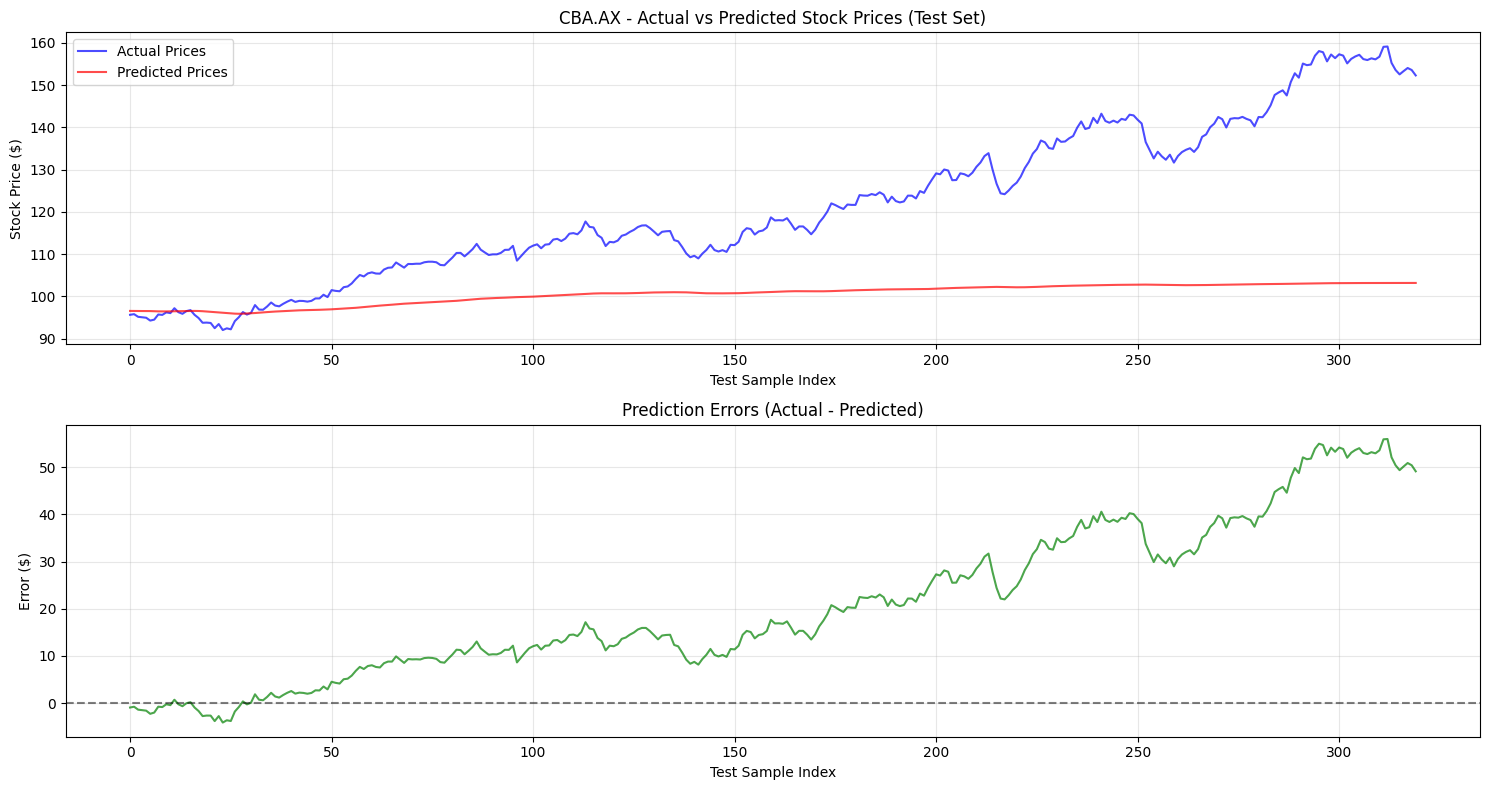


5 Best Predictions (Lowest Error):
          Date  Actual_Price  Predicted_Price  Absolute_Error  \
14  2023-10-17         96.51        96.510002            0.00   
30  2023-11-08         96.08        95.980003            0.10   
15  2023-10-18         96.72        96.519997            0.20   
9   2023-10-10         96.20        96.430000            0.23   
12  2023-10-13         96.24        96.480003            0.24   

    Percentage_Error  
14              0.00  
30              0.10  
15              0.21  
9               0.23  
12              0.25  

5 Worst Predictions (Highest Error):
           Date  Actual_Price  Predicted_Price  Absolute_Error  \
312  2024-12-18        159.14       103.160004           55.97   
311  2024-12-17        159.06       103.160004           55.91   
295  2024-11-25        158.05       103.080002           54.98   
296  2024-11-26        157.79       103.089996           54.69   
300  2024-12-02        157.29       103.120003           54.17   



In [8]:
#------------------------------------------------------------------------------
# 5) Make predictions on the test set
#------------------------------------------------------------------------------

print("Making predictions on test set...")

# Make predictions on test data
test_predictions = model.predict(X_test, verbose=0)
print(f"Test predictions shape: {test_predictions.shape}")

# Convert predictions back to original scale
original_test_predictions = inverse_transform_predictions(test_predictions, 'Close', scalers)
original_test_actual = inverse_transform_predictions(y_test.reshape(-1, 1), 'Close', scalers)

# Create a results DataFrame for better visualization
if 'Date' in test_data.columns:
    # Get corresponding dates for test predictions
    # Note: We need to account for the PREDICTION_DAYS offset
    test_dates = test_data['Date'].iloc[PREDICTION_DAYS:PREDICTION_DAYS + len(original_test_predictions)]
    
    results_df = pd.DataFrame({
        'Date': test_dates.values,
        'Actual_Price': original_test_actual,
        'Predicted_Price': original_test_predictions,
        'Absolute_Error': np.abs(original_test_actual - original_test_predictions),
        'Percentage_Error': np.abs((original_test_actual - original_test_predictions) / original_test_actual) * 100
    })
else:
    results_df = pd.DataFrame({
        'Actual_Price': original_test_actual,
        'Predicted_Price': original_test_predictions,
        'Absolute_Error': np.abs(original_test_actual - original_test_predictions),
        'Percentage_Error': np.abs((original_test_actual - original_test_predictions) / original_test_actual) * 100
    })

# Display prediction results
print("\n" + "="*60)
print("TEST SET PREDICTION RESULTS")
print("="*60)

print(f"Number of test predictions: {len(original_test_predictions)}")
print(f"Actual price range: ${original_test_actual.min():.2f} - ${original_test_actual.max():.2f}")
print(f"Predicted price range: ${original_test_predictions.min():.2f} - ${original_test_predictions.max():.2f}")

# Calculate detailed metrics
mae = np.mean(np.abs(original_test_actual - original_test_predictions))
mse = np.mean((original_test_actual - original_test_predictions) ** 2)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((original_test_actual - original_test_predictions) / original_test_actual)) * 100

print(f"\nPrediction Metrics:")
print(f"Mean Absolute Error (MAE): ${mae:.2f}")
print(f"Root Mean Square Error (RMSE): ${rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Prediction Accuracy: {100 - mape:.2f}%")

# Display sample predictions
print(f"\nSample Predictions (First 10):")
print(results_df.head(10).round(2))

print(f"\nSample Predictions (Last 10):")
print(results_df.tail(10).round(2))

# Save predictions to CSV
predictions_filename = f"{DATA_DIR}/{COMPANY}_test_predictions.csv"
results_df.to_csv(predictions_filename, index=False)
print(f"\nPredictions saved to: {predictions_filename}")

# Visualize predictions vs actual
plt.figure(figsize=(15, 8))
plt.subplot(2, 1, 1)
plt.plot(original_test_actual, label='Actual Prices', color='blue', alpha=0.7)
plt.plot(original_test_predictions, label='Predicted Prices', color='red', alpha=0.7)
plt.title(f'{COMPANY} - Actual vs Predicted Stock Prices (Test Set)')
plt.xlabel('Test Sample Index')
plt.ylabel('Stock Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot prediction errors
plt.subplot(2, 1, 2)
prediction_errors = original_test_actual - original_test_predictions
plt.plot(prediction_errors, color='green', alpha=0.7)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.title('Prediction Errors (Actual - Predicted)')
plt.xlabel('Test Sample Index')
plt.ylabel('Error ($)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{DATA_DIR}/{COMPANY}_prediction_results.png", dpi=300, bbox_inches='tight')
plt.show()

# Additional analysis: Best and worst predictions
best_predictions = results_df.nsmallest(5, 'Percentage_Error')
worst_predictions = results_df.nlargest(5, 'Percentage_Error')

print(f"\n5 Best Predictions (Lowest Error):")
print(best_predictions.round(2))

print(f"\n5 Worst Predictions (Highest Error):")
print(worst_predictions.round(2))

# Statistical summary of errors
print(f"\nError Distribution Summary:")
print(f"Error Statistics:")
print(f"  Mean Error: ${prediction_errors.mean():.2f}")
print(f"  Std Dev of Errors: ${prediction_errors.std():.2f}")
print(f"  Min Error: ${prediction_errors.min():.2f}")
print(f"  Max Error: ${prediction_errors.max():.2f}")
print(f"  25th Percentile: ${np.percentile(prediction_errors, 25):.2f}")
print(f"  75th Percentile: ${np.percentile(prediction_errors, 75):.2f}")

print("="*60)
print("PREDICTION ANALYSIS COMPLETE")
print("="*60)

Stock Market Candlestick Chart Display
Total data points available: 1266
Displaying charts for CBA.AX with 20 days per candlestick
Showing most recent 100 days for clarity
Displaying 5 candlesticks (100 most recent days)


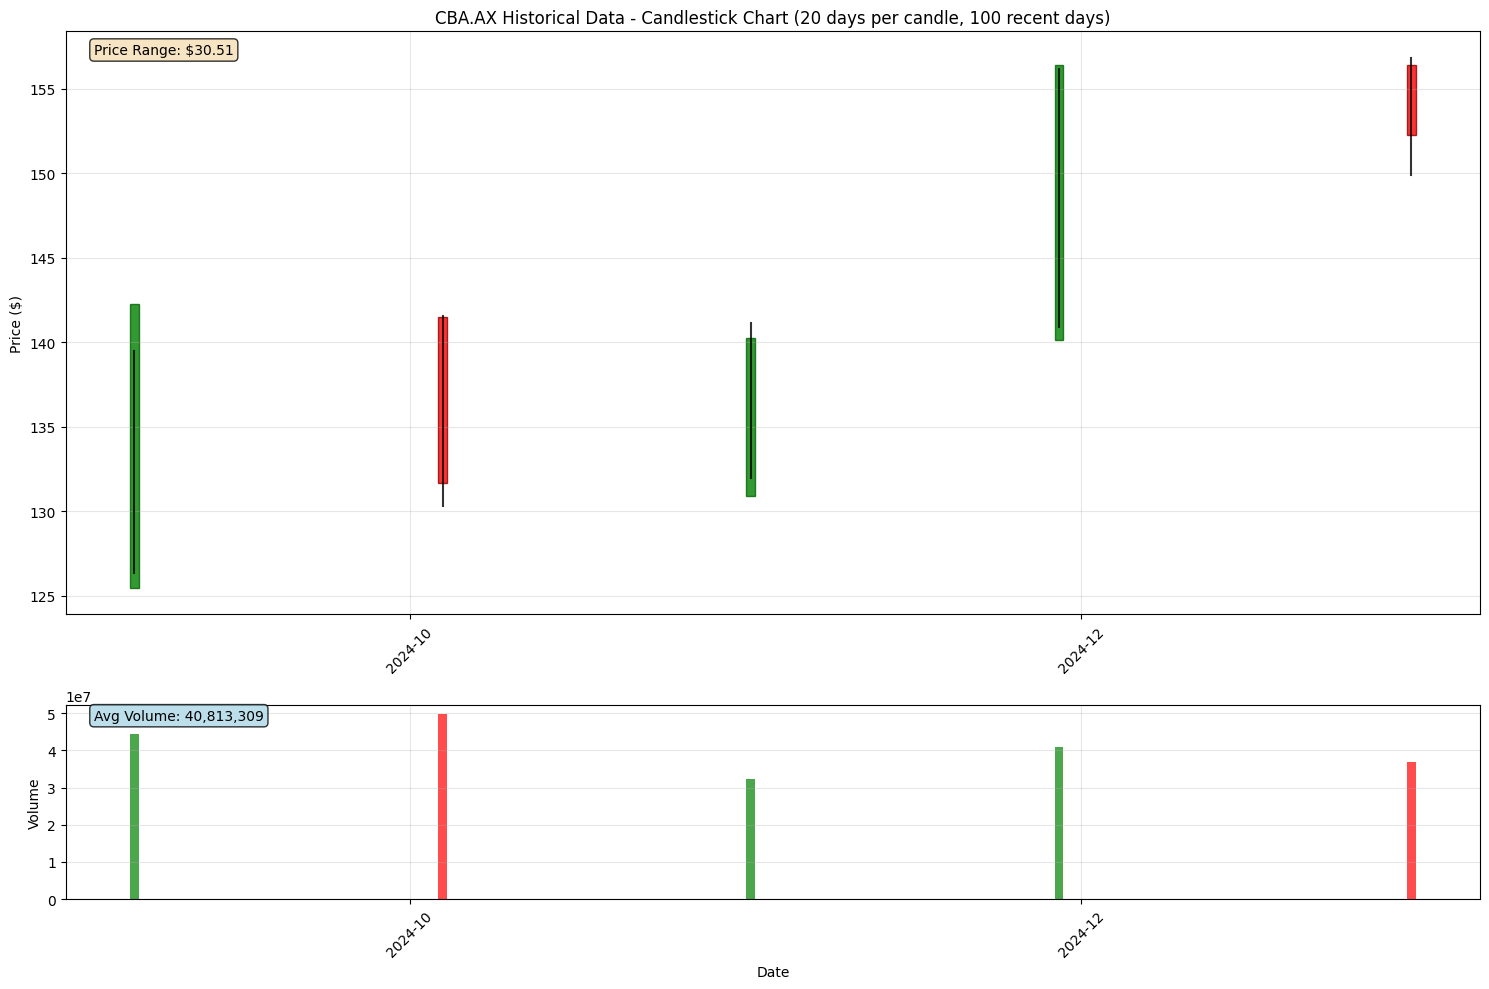


Displaying prediction comparison...


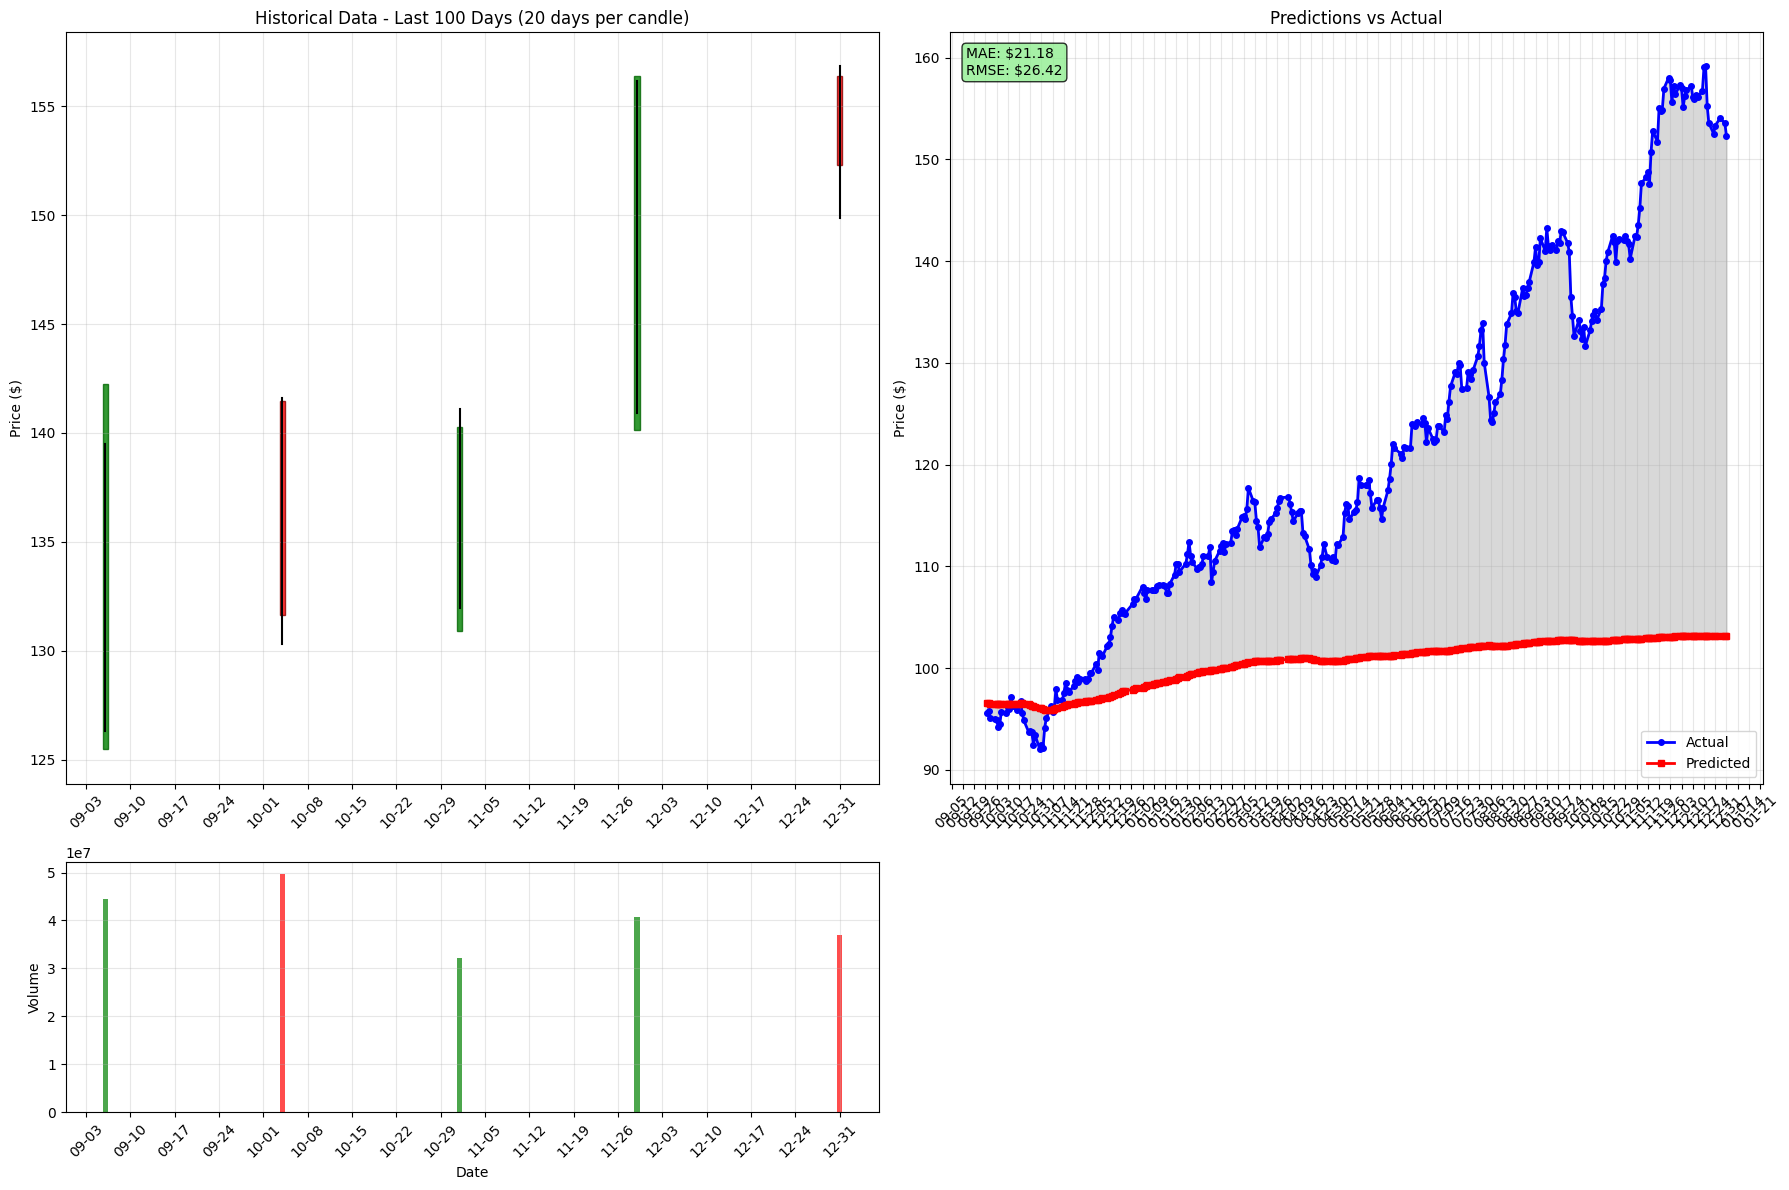

In [20]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.patches import Rectangle
import matplotlib.dates as mdates
from datetime import datetime, timedelta

def create_candlestick_data(df, n_days=1, limit_days=None):
    """
    Aggregate data for n trading days per candlestick with optional data limiting
    
    Parameters:
    df: DataFrame with columns ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
    n_days: Number of trading days per candlestick (n ≥ 1)
    limit_days: Limit to most recent N days (None for all data)
    
    Returns:
    DataFrame with aggregated candlestick data
    """
    df_filtered = df.copy()
    
    # Sort by date to ensure proper ordering
    df_filtered['Date'] = pd.to_datetime(df_filtered['Date'])
    df_filtered = df_filtered.sort_values('Date')
    
    # Limit data if specified
    if limit_days:
        df_filtered = df_filtered.tail(limit_days)
    
    if n_days == 1:
        return df_filtered
    
    # Group data by n_days intervals
    grouped_data = []
    for i in range(0, len(df_filtered), n_days):
        group = df_filtered.iloc[i:i+n_days]
        if len(group) > 0:
            aggregated = {
                'Date': group['Date'].iloc[-1],  # Use last date in group
                'Open': group['Open'].iloc[0],   # First open price
                'High': group['High'].max(),     # Highest high
                'Low': group['Low'].min(),       # Lowest low
                'Close': group['Close'].iloc[-1], # Last close price
                'Volume': group['Volume'].sum()   # Total volume
            }
            grouped_data.append(aggregated)
    
    return pd.DataFrame(grouped_data)

def plot_candlestick_chart(df, title="Stock Price", n_days=1, limit_days=90, figsize=(15, 10)):
    """
    Create a candlestick chart from stock data with better visibility
    
    Parameters:
    df: DataFrame with columns ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
    title: Chart title
    n_days: Number of trading days per candlestick
    limit_days: Limit to most recent N days (default: 90 days for better visibility)
    figsize: Figure size tuple
    """
    # Aggregate data if n_days > 1 and limit for better visibility
    candle_data = create_candlestick_data(df, n_days, limit_days)
    
    if len(candle_data) == 0:
        print("No data available for the specified parameters.")
        return
    
    print(f"Displaying {len(candle_data)} candlesticks ({limit_days} most recent days)")
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize, height_ratios=[3, 1])
    
    # Convert dates to matplotlib format
    dates = pd.to_datetime(candle_data['Date'])
    date_nums = mdates.date2num(dates)
    
    # Calculate dynamic width based on data density
    if len(candle_data) > 1:
        avg_spacing = np.mean(np.diff(date_nums))
        width = min(avg_spacing * 0.8, 0.8)  # Adaptive width
    else:
        width = 0.8
    
    # Plot candlesticks
    for i, (date_num, row) in enumerate(zip(date_nums, candle_data.itertuples())):
        open_price = row.Open
        high_price = row.High
        low_price = row.Low
        close_price = row.Close
        
        # Determine color (green for up, red for down)
        color = 'green' if close_price >= open_price else 'red'
        edge_color = 'darkgreen' if close_price >= open_price else 'darkred'
        
        # Draw the high-low line (wick)
        ax1.plot([date_num, date_num], [low_price, high_price], 
                color='black', linewidth=1.5, alpha=0.8)
        
        # Draw the open-close rectangle (body)
        height = abs(close_price - open_price)
        bottom = min(open_price, close_price)
        
        if height == 0:  # Doji candle
            height = (high_price - low_price) * 0.02  # Very thin line
            bottom = open_price - height/2
        
        rect = Rectangle((date_num - width/2, bottom), width, height, 
                        facecolor=color, edgecolor=edge_color, 
                        alpha=0.8, linewidth=1)
        ax1.add_patch(rect)
    
    # Format the main chart
    period_text = f"{n_days} day{'s' if n_days > 1 else ''}"
    ax1.set_title(f'{title} - Candlestick Chart ({period_text} per candle, {limit_days} recent days)')
    ax1.set_ylabel('Price ($)')
    ax1.grid(True, alpha=0.3)
    
    # Improved date formatting based on data range
    days_span = (dates.max() - dates.min()).days
    if days_span <= 30:
        ax1.xaxis.set_major_locator(mdates.WeekdayLocator())
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        ax1.xaxis.set_minor_locator(mdates.DayLocator())
    elif days_span <= 90:
        ax1.xaxis.set_major_locator(mdates.MonthLocator())
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        ax1.xaxis.set_minor_locator(mdates.WeekdayLocator())
    else:
        ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
    
    # Plot volume with matching colors
    colors = ['green' if close >= open else 'red' 
              for close, open in zip(candle_data['Close'], candle_data['Open'])]
    
    ax2.bar(date_nums, candle_data['Volume'], color=colors, alpha=0.7, width=width)
    ax2.set_ylabel('Volume')
    ax2.set_xlabel('Date')
    ax2.grid(True, alpha=0.3)
    
    # Match date formatting for volume chart
    ax2.xaxis.set_major_locator(ax1.xaxis.get_major_locator())
    ax2.xaxis.set_major_formatter(ax1.xaxis.get_major_formatter())
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
    
    # Add price range and volume info
    price_range = candle_data['High'].max() - candle_data['Low'].min()
    avg_volume = candle_data['Volume'].mean()
    
    ax1.text(0.02, 0.98, f'Price Range: ${price_range:.2f}', 
             transform=ax1.transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    ax2.text(0.02, 0.98, f'Avg Volume: {avg_volume:,.0f}', 
             transform=ax2.transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

def plot_prediction_comparison(historical_df, predictions_df, n_days=1, limit_days=60, figsize=(18, 12)):
    """
    Plot historical data and predictions with better visibility
    
    Parameters:
    historical_df: DataFrame with historical data
    predictions_df: DataFrame with predictions
    n_days: Number of trading days per candlestick
    limit_days: Limit historical data for better visibility
    figsize: Figure size tuple
    """
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=figsize, height_ratios=[3, 1])
    
    # Plot historical data (limited for clarity)
    historical_candles = create_candlestick_data(historical_df, n_days, limit_days)
    dates_hist = pd.to_datetime(historical_candles['Date'])
    date_nums_hist = mdates.date2num(dates_hist)
    
    # Calculate width for historical data
    if len(historical_candles) > 1:
        width_hist = min(np.mean(np.diff(date_nums_hist)) * 0.8, 0.8)
    else:
        width_hist = 0.8
    
    # Historical candlesticks
    for i, (date_num, row) in enumerate(zip(date_nums_hist, historical_candles.itertuples())):
        open_price = row.Open
        high_price = row.High
        low_price = row.Low
        close_price = row.Close
        
        color = 'green' if close_price >= open_price else 'red'
        edge_color = 'darkgreen' if close_price >= open_price else 'darkred'
        
        ax1.plot([date_num, date_num], [low_price, high_price], 
                color='black', linewidth=1.5)
        
        height = abs(close_price - open_price)
        bottom = min(open_price, close_price)
        
        if height == 0:
            height = (high_price - low_price) * 0.02
            bottom = open_price - height/2
        
        rect = Rectangle((date_num - width_hist/2, bottom), width_hist, height, 
                        facecolor=color, edgecolor=edge_color, alpha=0.8)
        ax1.add_patch(rect)
    
    # Historical volume
    colors_hist = ['green' if close >= open else 'red' 
                   for close, open in zip(historical_candles['Close'], historical_candles['Open'])]
    ax3.bar(date_nums_hist, historical_candles['Volume'], color=colors_hist, 
            alpha=0.7, width=width_hist)
    
    # Plot predictions
    if 'Actual_Price' in predictions_df.columns:
        dates_pred = pd.to_datetime(predictions_df['Date']) if 'Date' in predictions_df.columns else range(len(predictions_df))
        ax2.plot(dates_pred, predictions_df['Actual_Price'], 
                color='blue', label='Actual', linewidth=2, marker='o', markersize=4)
        ax2.plot(dates_pred, predictions_df['Predicted_Price'], 
                color='red', label='Predicted', linewidth=2, marker='s', markersize=4)
        ax2.fill_between(dates_pred, predictions_df['Actual_Price'], 
                        predictions_df['Predicted_Price'], alpha=0.3, color='gray')
        
        # Calculate and display accuracy metrics
        mae = np.mean(np.abs(predictions_df['Actual_Price'] - predictions_df['Predicted_Price']))
        rmse = np.sqrt(np.mean((predictions_df['Actual_Price'] - predictions_df['Predicted_Price'])**2))
        ax2.text(0.02, 0.98, f'MAE: ${mae:.2f}\nRMSE: ${rmse:.2f}', 
                transform=ax2.transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))
    else:
        dates_pred = pd.to_datetime(predictions_df['Date']) if 'Date' in predictions_df.columns else range(len(predictions_df))
        ax2.plot(dates_pred, predictions_df['Predicted_Price'], 
                color='red', label='Predicted', linewidth=2, marker='s', markersize=4)
    
    # Format charts
    period_text = f"{n_days} day{'s' if n_days > 1 else ''}"
    ax1.set_title(f'Historical Data - Last {limit_days} Days ({period_text} per candle)')
    ax1.set_ylabel('Price ($)')
    ax1.grid(True, alpha=0.3)
    
    ax2.set_title('Predictions vs Actual')
    ax2.set_ylabel('Price ($)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    ax3.set_ylabel('Volume')
    ax3.set_xlabel('Date')
    ax3.grid(True, alpha=0.3)
    
    ax4.axis('off')  # Hide the fourth subplot
    
    # Improved date formatting
    for ax in [ax1, ax2, ax3]:
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        ax.xaxis.set_major_locator(mdates.WeekdayLocator())
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
    
    plt.tight_layout()
    plt.show()

def display_stock_charts(company='CBA.AX', n_days=1, limit_days=90):
    """
    Display candlestick charts with improved visibility
    
    Parameters:
    company: Stock symbol (default: 'CBA.AX')
    n_days: Number of trading days per candlestick
    limit_days: Limit to most recent N days for better visibility
    """
    try:
        df = pd.read_csv(f'data/{company}_cleaned_data.csv')
        
        # Ensure we have the required columns
        if 'Open' not in df.columns:
            df['Open'] = df['Price'].shift(1).fillna(df['Price'])
        if 'High' not in df.columns:
            df['High'] = df['Price'] * 1.01
        if 'Low' not in df.columns:
            df['Low'] = df['Price'] * 0.99
        if 'Close' not in df.columns:
            df['Close'] = df['Price']
        
        print(f"Total data points available: {len(df)}")
        print(f"Displaying charts for {company} with {n_days} day{'s' if n_days > 1 else ''} per candlestick")
        print(f"Showing most recent {limit_days} days for clarity")
        
        # Plot historical data with limited timeframe
        plot_candlestick_chart(df, title=f"{company} Historical Data", 
                             n_days=n_days, limit_days=limit_days)
        
        # Load predictions if available
        try:
            predictions_df = pd.read_csv(f'data/{company}_test_predictions.csv')
            print("\nDisplaying prediction comparison...")
            plot_prediction_comparison(df, predictions_df, n_days=n_days, limit_days=limit_days)
        except FileNotFoundError:
            print(f"Prediction file not found: data/{company}_test_predictions.csv")
            print("Only showing historical data.")
            
    except FileNotFoundError:
        print(f"Data file not found: data/{company}_cleaned_data.csv")
        print("Please ensure your data files exist in the data directory.")

def interactive_chart_display():
    """
    Enhanced interactive function with better visibility options
    """
    print("Stock Market Candlestick Chart Display")
    print("=" * 40)
    
    try:
        n_days = int(input("Enter number of trading days per candlestick (n ≥ 1): "))
        if n_days < 1:
            print("Invalid input. Using default value of 1 day per candlestick.")
            n_days = 1
    except ValueError:
        print("Invalid input. Using default value of 1 day per candlestick.")
        n_days = 1
    
    try:
        if n_days == 1:
            default_limit = 60  # Show 2 months for daily candles
            limit_days = int(input(f"Enter number of recent days to display (default {default_limit} for clarity): ") or default_limit)
        else:
            default_limit = 200  # Show more data for aggregated candles
            limit_days = int(input(f"Enter number of recent days to display (default {default_limit}): ") or default_limit)
    except ValueError:
        limit_days = 60 if n_days == 1 else 200
    
    company = input("Enter company symbol (or press Enter for CBA.AX): ").strip()
    if not company:
        company = 'CBA.AX'
    
    display_stock_charts(company, n_days, limit_days)

# Usage examples with better defaults
if __name__ == "__main__":
    # Example 1: Daily candles with limited timeframe for clarity
    # display_stock_charts('CBA.AX', n_days=1, limit_days=60)
    
    # Example 2: Weekly candles (5-day aggregation)
    # display_stock_charts('CBA.AX', n_days=5, limit_days=200)
    
    # Example 3: Interactive mode
    interactive_chart_display()

Stock Market Candlestick Chart Display
Invalid input. Using default value of 1 day per candlestick.
Displaying charts for CBA.AX with 1 day per candlestick


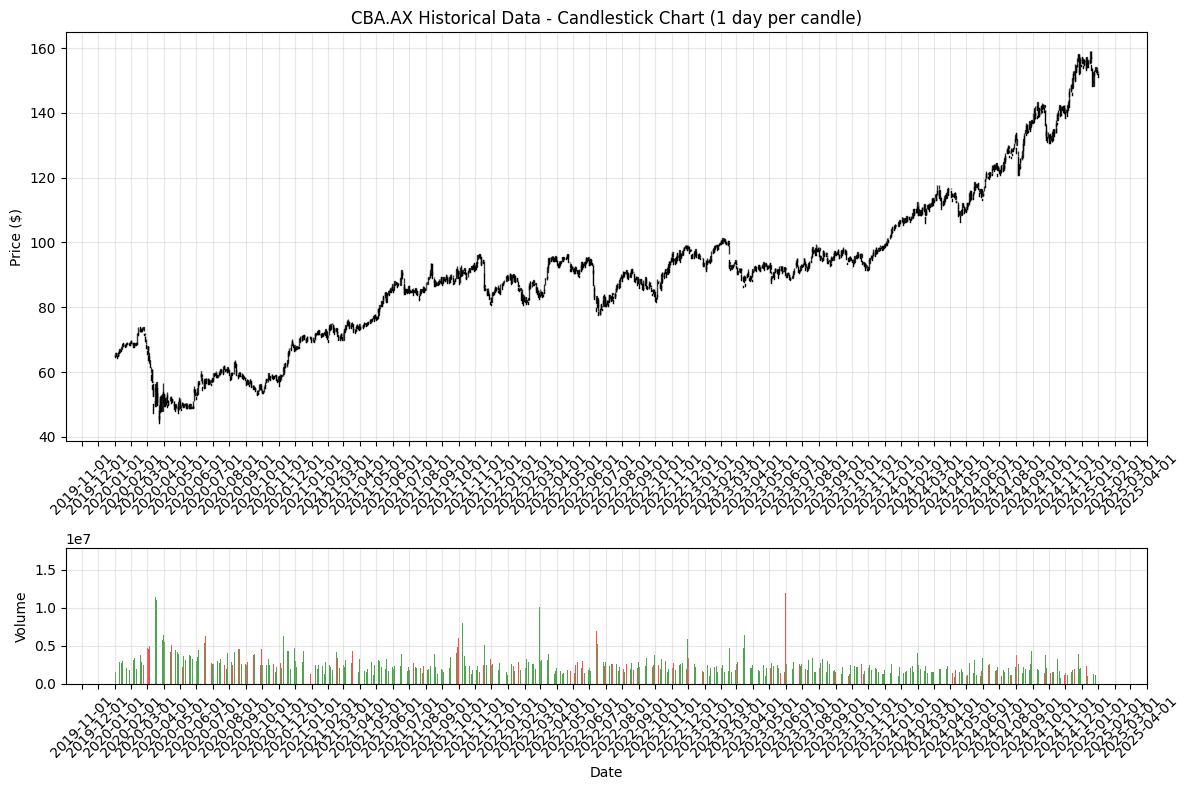


Displaying prediction comparison...


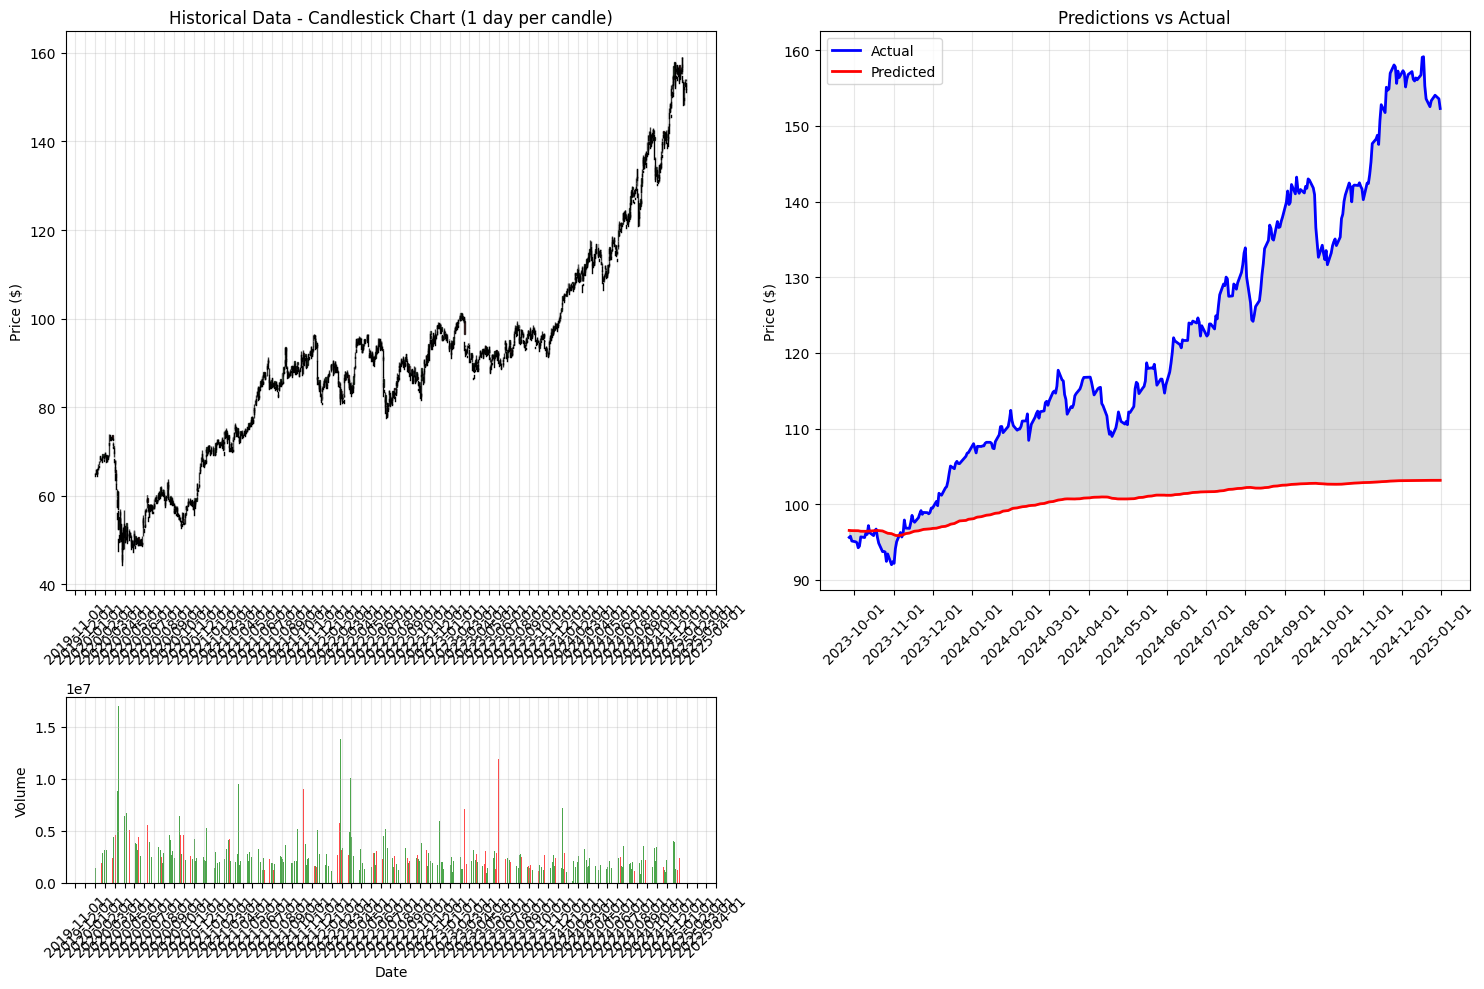

In [21]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.patches import Rectangle
import matplotlib.dates as mdates
from datetime import datetime, timedelta

def create_candlestick_data(df, n_days=1):
    """
    Aggregate data for n trading days per candlestick
    
    Parameters:
    df: DataFrame with columns ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
    n_days: Number of trading days per candlestick (n ≥ 1)
    
    Returns:
    DataFrame with aggregated candlestick data
    """
    if n_days == 1:
        return df.copy()
    
    # Group data by n_days intervals
    grouped_data = []
    for i in range(0, len(df), n_days):
        group = df.iloc[i:i+n_days]
        if len(group) > 0:
            aggregated = {
                'Date': group['Date'].iloc[-1],  # Use last date in group
                'Open': group['Open'].iloc[0],   # First open price
                'High': group['High'].max(),     # Highest high
                'Low': group['Low'].min(),       # Lowest low
                'Close': group['Close'].iloc[-1], # Last close price
                'Volume': group['Volume'].sum()   # Total volume
            }
            grouped_data.append(aggregated)
    
    return pd.DataFrame(grouped_data)

def plot_candlestick_chart(df, title="Stock Price", n_days=1, figsize=(12, 8)):
    """
    Create a candlestick chart from stock data
    
    Parameters:
    df: DataFrame with columns ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
    title: Chart title
    n_days: Number of trading days per candlestick
    figsize: Figure size tuple
    """
    # Aggregate data if n_days > 1
    candle_data = create_candlestick_data(df, n_days)
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize, height_ratios=[3, 1])
    
    # Convert dates to matplotlib format
    dates = pd.to_datetime(candle_data['Date'])
    date_nums = mdates.date2num(dates)
    
    # Plot candlesticks
    for i, (date_num, row) in enumerate(zip(date_nums, candle_data.itertuples())):
        open_price = row.Open
        high_price = row.High
        low_price = row.Low
        close_price = row.Close
        
        # Determine color (green for up, red for down)
        color = 'green' if close_price >= open_price else 'red'
        
        # Draw the high-low line
        ax1.plot([date_num, date_num], [low_price, high_price], color='black', linewidth=1)
        
        # Draw the open-close rectangle
        height = abs(close_price - open_price)
        bottom = min(open_price, close_price)
        width = 0.6 if n_days == 1 else 0.6 * n_days
        
        rect = Rectangle((date_num - width/2, bottom), width, height, 
                        facecolor=color, edgecolor='black', alpha=0.8)
        ax1.add_patch(rect)
    
    # Format the main chart
    ax1.set_title(f'{title} - Candlestick Chart ({n_days} day{"s" if n_days > 1 else ""} per candle)')
    ax1.set_ylabel('Price ($)')
    ax1.grid(True, alpha=0.3)
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax1.xaxis.set_major_locator(mdates.MonthLocator())
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
    
    # Plot volume
    colors = ['green' if close >= open else 'red' 
              for close, open in zip(candle_data['Close'], candle_data['Open'])]
    ax2.bar(date_nums, candle_data['Volume'], color=colors, alpha=0.7, width=0.6 if n_days == 1 else 0.6 * n_days)
    ax2.set_ylabel('Volume')
    ax2.set_xlabel('Date')
    ax2.grid(True, alpha=0.3)
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax2.xaxis.set_major_locator(mdates.MonthLocator())
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
    
    plt.tight_layout()
    plt.show()

def plot_prediction_comparison(historical_df, predictions_df, n_days=1, figsize=(15, 10)):
    """
    Plot historical data and predictions side by side using candlestick charts
    
    Parameters:
    historical_df: DataFrame with historical data
    predictions_df: DataFrame with predictions (should have Date, Predicted_Price columns)
    n_days: Number of trading days per candlestick
    figsize: Figure size tuple
    """
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=figsize, height_ratios=[3, 1])
    
    # Plot historical data
    historical_candles = create_candlestick_data(historical_df, n_days)
    dates_hist = pd.to_datetime(historical_candles['Date'])
    date_nums_hist = mdates.date2num(dates_hist)
    
    # Historical candlesticks
    for i, (date_num, row) in enumerate(zip(date_nums_hist, historical_candles.itertuples())):
        open_price = row.Open
        high_price = row.High
        low_price = row.Low
        close_price = row.Close
        
        color = 'green' if close_price >= open_price else 'red'
        
        ax1.plot([date_num, date_num], [low_price, high_price], color='black', linewidth=1)
        
        height = abs(close_price - open_price)
        bottom = min(open_price, close_price)
        width = 0.6 if n_days == 1 else 0.6 * n_days
        
        rect = Rectangle((date_num - width/2, bottom), width, height, 
                        facecolor=color, edgecolor='black', alpha=0.8)
        ax1.add_patch(rect)
    
    # Historical volume
    colors_hist = ['green' if close >= open else 'red' 
                   for close, open in zip(historical_candles['Close'], historical_candles['Open'])]
    ax3.bar(date_nums_hist, historical_candles['Volume'], color=colors_hist, alpha=0.7, 
            width=0.6 if n_days == 1 else 0.6 * n_days)
    
    # Plot predictions (assuming we have actual vs predicted data)
    if 'Actual_Price' in predictions_df.columns:
        dates_pred = pd.to_datetime(predictions_df['Date'])
        ax2.plot(dates_pred, predictions_df['Actual_Price'], color='blue', label='Actual', linewidth=2)
        ax2.plot(dates_pred, predictions_df['Predicted_Price'], color='red', label='Predicted', linewidth=2)
        ax2.fill_between(dates_pred, predictions_df['Actual_Price'], predictions_df['Predicted_Price'], 
                        alpha=0.3, color='gray')
    else:
        # If only predictions available
        dates_pred = pd.to_datetime(predictions_df['Date']) if 'Date' in predictions_df.columns else range(len(predictions_df))
        ax2.plot(dates_pred, predictions_df['Predicted_Price'], color='red', label='Predicted', linewidth=2)
    
    # Format charts
    ax1.set_title(f'Historical Data - Candlestick Chart ({n_days} day{"s" if n_days > 1 else ""} per candle)')
    ax1.set_ylabel('Price ($)')
    ax1.grid(True, alpha=0.3)
    
    ax2.set_title('Predictions vs Actual')
    ax2.set_ylabel('Price ($)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    ax3.set_ylabel('Volume')
    ax3.set_xlabel('Date')
    ax3.grid(True, alpha=0.3)
    
    ax4.axis('off')  # Hide the fourth subplot
    
    # Format dates
    for ax in [ax1, ax2, ax3]:
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax.xaxis.set_major_locator(mdates.MonthLocator())
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
    
    plt.tight_layout()
    plt.show()

# Example usage function for your workspace
def display_stock_charts(company='CBA.AX', n_days=1):
    """
    Display candlestick charts for your stock prediction data
    
    Parameters:
    company: Stock symbol (default: 'CBA.AX')
    n_days: Number of trading days per candlestick
    """
    # Load your cleaned data
    try:
        df = pd.read_csv(f'data/{company}_cleaned_data.csv')
        
        # Ensure we have the required columns
        if 'Open' not in df.columns:
            # Create Open from Price if not available
            df['Open'] = df['Price'].shift(1).fillna(df['Price'])
        
        print(f"Displaying charts for {company} with {n_days} day{'s' if n_days > 1 else ''} per candlestick")
        
        # Plot historical data
        plot_candlestick_chart(df, title=f"{company} Historical Data", n_days=n_days)
        
        # Load predictions if available
        try:
            predictions_df = pd.read_csv(f'data/{company}_test_predictions.csv')
            print("\nDisplaying prediction comparison...")
            plot_prediction_comparison(df, predictions_df, n_days=n_days)
        except FileNotFoundError:
            print(f"Prediction file not found: data/{company}_test_predictions.csv")
            print("Only showing historical data.")
            
    except FileNotFoundError:
        print(f"Data file not found: data/{company}_cleaned_data.csv")
        print("Please ensure your data files exist in the data directory.")

# Interactive function to get user input for n_days
def interactive_chart_display():
    """
    Interactive function to display charts with user-specified parameters
    """
    print("Stock Market Candlestick Chart Display")
    print("=" * 40)
    
    try:
        n_days = int(input("Enter number of trading days per candlestick (n ≥ 1): "))
        if n_days < 1:
            print("Invalid input. Using default value of 1 day per candlestick.")
            n_days = 1
    except ValueError:
        print("Invalid input. Using default value of 1 day per candlestick.")
        n_days = 1
    
    company = input("Enter company symbol (or press Enter for CBA.AX): ").strip()
    if not company:
        company = 'CBA.AX'
    
    display_stock_charts(company, n_days)

# Call this function to run the interactive chart display
if __name__ == "__main__":
    interactive_chart_display()

Stock Market Boxplot Chart Display

Select time period for analysis:
1. Daily
2. Weekly
3. Monthly
4. Quarterly
5. Yearly
Available columns: ['Date', 'Price', 'Close', 'High', 'Low', 'Volume']
Displaying boxplot charts for CBA.AX grouped by monthly


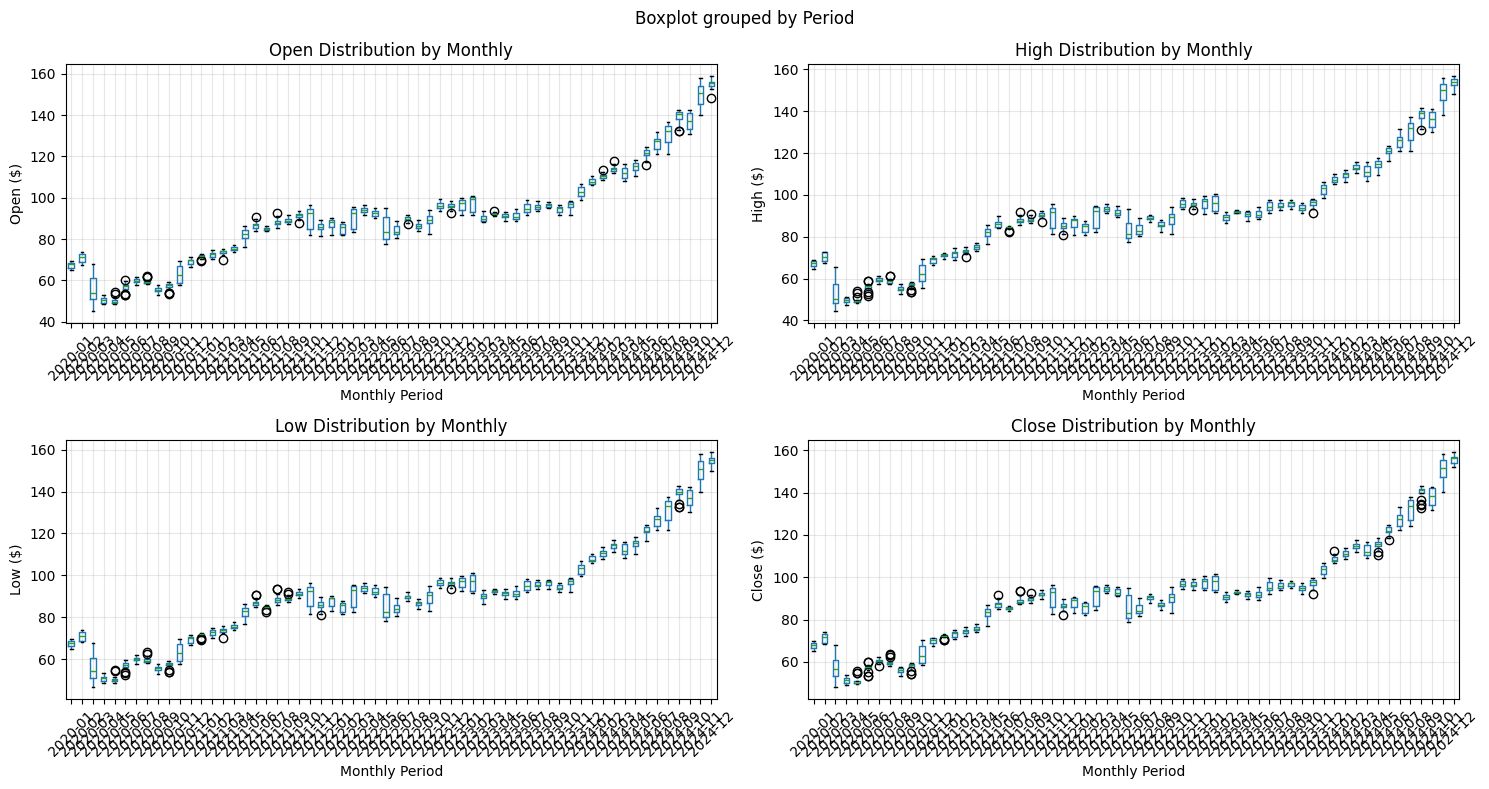

<Figure size 1000x600 with 0 Axes>

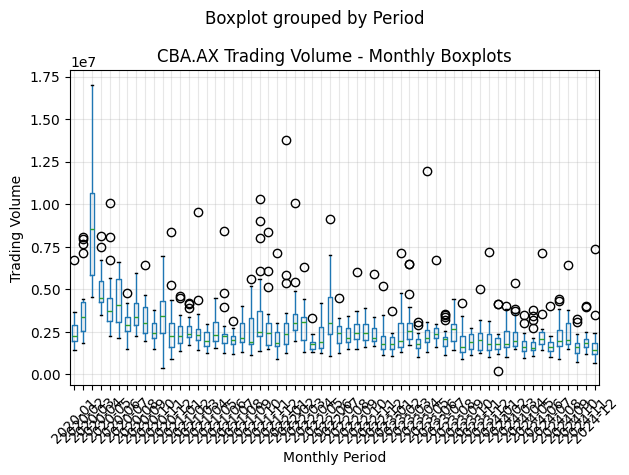

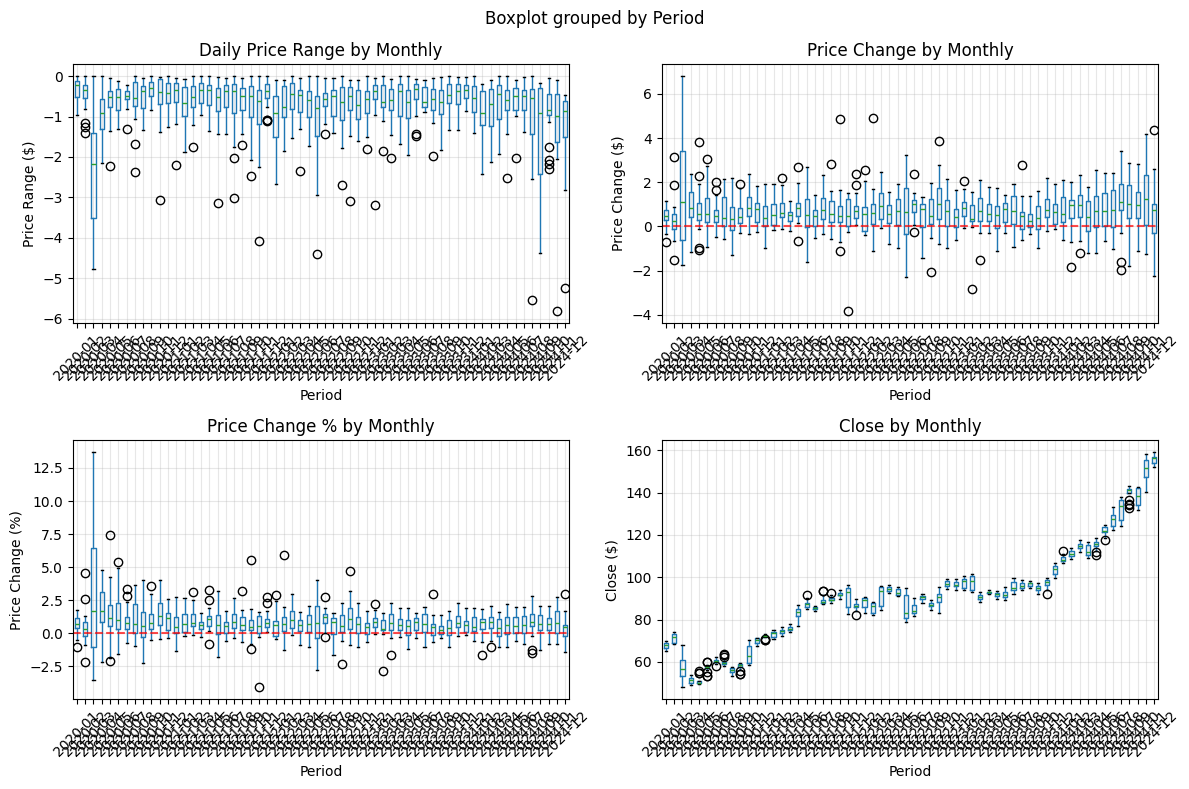

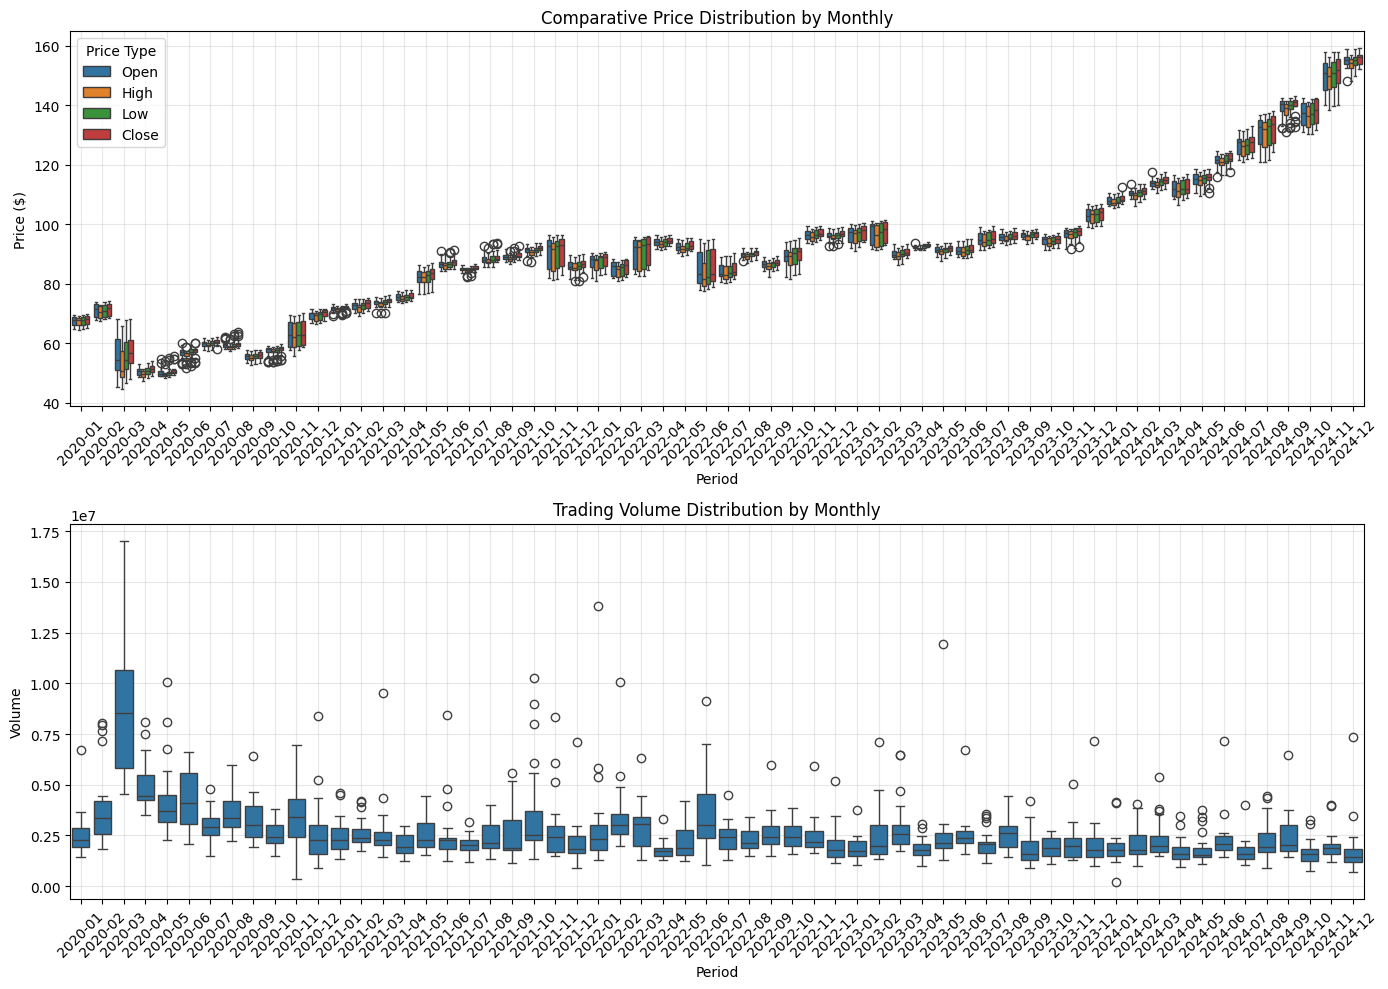


CBA.AX Summary Statistics:
             Price        Close         High          Low        Volume  \
count  1266.000000  1266.000000  1266.000000  1266.000000  1.266000e+03   
mean     90.753151    91.371841    90.039553    90.738492  2.687015e+06   
std      23.397385    23.395018    23.279322    23.352523  1.632867e+06   
min      45.106667    48.049491    44.424996    46.561455  2.072400e+05   
25%      74.727188    75.212093    74.177402    74.614922  1.733119e+06   
50%      90.340115    90.973735    89.621637    90.371996  2.239846e+06   
75%      97.565275    98.208614    96.956660    97.719938  3.049415e+06   
max     158.900345   159.137020   156.829404   158.870767  1.702197e+07   

              Open  
count  1266.000000  
mean     90.685066  
std      23.346913  
min      45.106667  
25%      74.713366  
50%      90.315353  
75%      97.540424  
max     158.900345  


In [22]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta

def create_boxplot_data(df, period='monthly'):
    """
    Prepare data for boxplot visualization by grouping into periods
    
    Parameters:
    df: DataFrame with columns ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
    period: Grouping period ('daily', 'weekly', 'monthly', 'quarterly', 'yearly')
    
    Returns:
    DataFrame with period labels and price data
    """
    df_copy = df.copy()
    df_copy['Date'] = pd.to_datetime(df_copy['Date'])
    
    # Create period labels based on the specified period
    if period == 'daily':
        df_copy['Period'] = df_copy['Date'].dt.strftime('%Y-%m-%d')
    elif period == 'weekly':
        df_copy['Period'] = df_copy['Date'].dt.strftime('%Y-W%U')
    elif period == 'monthly':
        df_copy['Period'] = df_copy['Date'].dt.strftime('%Y-%m')
    elif period == 'quarterly':
        df_copy['Period'] = df_copy['Date'].dt.to_period('Q').astype(str)
    elif period == 'yearly':
        df_copy['Period'] = df_copy['Date'].dt.strftime('%Y')
    else:
        df_copy['Period'] = df_copy['Date'].dt.strftime('%Y-%m')  # Default to monthly
    
    return df_copy

def plot_price_boxplot(df, period='monthly', price_columns=['Open', 'High', 'Low', 'Close'], 
                       figsize=(15, 8), title="Stock Price Distribution"):
    """
    Create boxplot chart for stock price data
    
    Parameters:
    df: DataFrame with stock data
    period: Time period for grouping ('daily', 'weekly', 'monthly', 'quarterly', 'yearly')
    price_columns: List of price columns to display
    figsize: Figure size tuple
    title: Chart title
    """
    # Prepare data
    boxplot_data = create_boxplot_data(df, period)
    
    # Filter price columns that actually exist in the dataframe
    available_price_columns = [col for col in price_columns if col in boxplot_data.columns]
    
    if not available_price_columns:
        print("No price columns found. Using 'Price' column if available.")
        if 'Price' in boxplot_data.columns:
            available_price_columns = ['Price']
        else:
            print("No suitable price columns found.")
            return
    
    # Create subplots based on available columns
    n_cols = min(2, len(available_price_columns))
    n_rows = (len(available_price_columns) + 1) // 2
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    fig.suptitle(f'{title} - {period.capitalize()} Boxplots', fontsize=16, fontweight='bold')
    
    # Handle single subplot case
    if len(available_price_columns) == 1:
        axes = [axes] if not isinstance(axes, np.ndarray) else axes.flatten()
    elif isinstance(axes, np.ndarray):
        axes = axes.flatten()
    else:
        axes = [axes]
    
    # Create boxplot for each available price column
    for i, column in enumerate(available_price_columns):
        if i < len(axes):
            # Create boxplot
            boxplot_data.boxplot(column=column, by='Period', ax=axes[i])
            axes[i].set_title(f'{column} Distribution by {period.capitalize()}')
            axes[i].set_xlabel(f'{period.capitalize()} Period')
            axes[i].set_ylabel(f'{column} ($)')
            axes[i].grid(True, alpha=0.3)
            
            # Rotate x-axis labels for better readability
            axes[i].tick_params(axis='x', rotation=45)
    
    # Hide unused subplots
    for i in range(len(available_price_columns), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()

def plot_volume_boxplot(df, period='monthly', figsize=(10, 6), title="Trading Volume Distribution"):
    """
    Create boxplot chart for trading volume data
    
    Parameters:
    df: DataFrame with stock data
    period: Time period for grouping
    figsize: Figure size tuple
    title: Chart title
    """
    # Prepare data
    boxplot_data = create_boxplot_data(df, period)
    
    if 'Volume' not in boxplot_data.columns:
        print("Volume column not found. Skipping volume boxplot.")
        return
    
    plt.figure(figsize=figsize)
    
    # Create volume boxplot
    boxplot_data.boxplot(column='Volume', by='Period')
    plt.title(f'{title} - {period.capitalize()} Boxplots')
    plt.xlabel(f'{period.capitalize()} Period')
    plt.ylabel('Trading Volume')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def plot_price_range_boxplot(df, period='monthly', figsize=(12, 8), title="Price Range Analysis"):
    """
    Create boxplot showing price ranges and volatility
    
    Parameters:
    df: DataFrame with stock data
    period: Time period for grouping
    figsize: Figure size tuple
    title: Chart title
    """
    # Prepare data and calculate additional metrics
    boxplot_data = create_boxplot_data(df, period)
    
    # Calculate metrics based on available columns
    if 'High' in boxplot_data.columns and 'Low' in boxplot_data.columns:
        boxplot_data['Daily_Range'] = boxplot_data['High'] - boxplot_data['Low']
    elif 'Price' in boxplot_data.columns:
        # Approximate range using price volatility
        boxplot_data['Daily_Range'] = boxplot_data.groupby('Period')['Price'].transform(lambda x: x.max() - x.min())
    
    if 'Close' in boxplot_data.columns and 'Open' in boxplot_data.columns:
        boxplot_data['Price_Change'] = boxplot_data['Close'] - boxplot_data['Open']
        boxplot_data['Price_Change_Pct'] = (boxplot_data['Price_Change'] / boxplot_data['Open']) * 100
    elif 'Price' in boxplot_data.columns:
        # Calculate price change using price differences
        boxplot_data['Price_Change'] = boxplot_data['Price'].diff()
        boxplot_data['Price_Change_Pct'] = (boxplot_data['Price_Change'] / boxplot_data['Price'].shift(1)) * 100
    
    # Determine which metrics are available
    available_metrics = []
    if 'Daily_Range' in boxplot_data.columns:
        available_metrics.append('Daily_Range')
    if 'Price_Change' in boxplot_data.columns:
        available_metrics.append('Price_Change')
    if 'Price_Change_Pct' in boxplot_data.columns:
        available_metrics.append('Price_Change_Pct')
    
    close_col = 'Close' if 'Close' in boxplot_data.columns else 'Price'
    if close_col in boxplot_data.columns:
        available_metrics.append(close_col)
    
    if not available_metrics:
        print("No suitable metrics found for price range analysis.")
        return
    
    # Create subplots
    n_metrics = len(available_metrics)
    n_cols = 2
    n_rows = (n_metrics + 1) // 2
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    fig.suptitle(f'{title} - {period.capitalize()} Analysis', fontsize=16, fontweight='bold')
    
    if n_rows == 1:
        axes = axes if isinstance(axes, np.ndarray) else [axes]
    else:
        axes = axes.flatten()
    
    # Plot available metrics
    for i, metric in enumerate(available_metrics):
        if i < len(axes):
            boxplot_data.boxplot(column=metric, by='Period', ax=axes[i])
            
            if metric == 'Daily_Range':
                axes[i].set_title(f'Daily Price Range by {period.capitalize()}')
                axes[i].set_ylabel('Price Range ($)')
            elif metric == 'Price_Change':
                axes[i].set_title(f'Price Change by {period.capitalize()}')
                axes[i].set_ylabel('Price Change ($)')
                axes[i].axhline(y=0, color='red', linestyle='--', alpha=0.7)
            elif metric == 'Price_Change_Pct':
                axes[i].set_title(f'Price Change % by {period.capitalize()}')
                axes[i].set_ylabel('Price Change (%)')
                axes[i].axhline(y=0, color='red', linestyle='--', alpha=0.7)
            else:
                axes[i].set_title(f'{metric} by {period.capitalize()}')
                axes[i].set_ylabel(f'{metric} ($)')
            
            axes[i].tick_params(axis='x', rotation=45)
            axes[i].grid(True, alpha=0.3)
    
    # Hide unused subplots
    for i in range(len(available_metrics), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()

def plot_comparative_boxplot(df, comparison_type='quarterly', figsize=(14, 10)):
    """
    Create comparative boxplots using seaborn for better visualization
    
    Parameters:
    df: DataFrame with stock data
    comparison_type: Type of comparison ('monthly', 'quarterly', 'yearly')
    figsize: Figure size tuple
    """
    # Prepare data
    boxplot_data = create_boxplot_data(df, comparison_type)
    
    # Determine available price columns
    price_columns = ['Open', 'High', 'Low', 'Close']
    available_price_columns = [col for col in price_columns if col in boxplot_data.columns]
    
    if not available_price_columns:
        if 'Price' in boxplot_data.columns:
            available_price_columns = ['Price']
        else:
            print("No suitable price columns found for comparative analysis.")
            return
    
    # Create the plot
    if len(available_price_columns) > 1:
        # Melt the data for seaborn - use unique value_name
        melted_data = pd.melt(boxplot_data, 
                             id_vars=['Period'], 
                             value_vars=available_price_columns,
                             var_name='Price_Type', 
                             value_name='Stock_Price')  # Changed from 'Price' to 'Stock_Price'
        
        fig, axes = plt.subplots(2, 1, figsize=figsize)
        
        # Comparative price boxplot
        sns.boxplot(data=melted_data, x='Period', y='Stock_Price', hue='Price_Type', ax=axes[0])
        axes[0].set_title(f'Comparative Price Distribution by {comparison_type.capitalize()}')
        axes[0].set_ylabel('Price ($)')
        axes[0].tick_params(axis='x', rotation=45)
        axes[0].grid(True, alpha=0.3)
        axes[0].legend(title='Price Type')
        
        # Volume boxplot (if available)
        if 'Volume' in boxplot_data.columns:
            sns.boxplot(data=boxplot_data, x='Period', y='Volume', ax=axes[1])
            axes[1].set_title(f'Trading Volume Distribution by {comparison_type.capitalize()}')
            axes[1].set_ylabel('Volume')
            axes[1].tick_params(axis='x', rotation=45)
            axes[1].grid(True, alpha=0.3)
        else:
            axes[1].set_visible(False)
    else:
        # Single price column case
        fig, ax = plt.subplots(1, 1, figsize=(figsize[0], figsize[1]//2))
        
        price_col = available_price_columns[0]
        sns.boxplot(data=boxplot_data, x='Period', y=price_col, ax=ax)
        ax.set_title(f'{price_col} Distribution by {comparison_type.capitalize()}')
        ax.set_ylabel('Price ($)')
        ax.tick_params(axis='x', rotation=45)
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def display_stock_boxplots(company='CBA.AX', period='monthly'):
    """
    Display various boxplot charts for your stock data
    
    Parameters:
    company: Stock symbol (default: 'CBA.AX')
    period: Time period for analysis ('daily', 'weekly', 'monthly', 'quarterly', 'yearly')
    """
    try:
        # Load your cleaned data
        df = pd.read_csv(f'data/{company}_cleaned_data.csv')
        
        print(f"Available columns: {list(df.columns)}")
        
        # Ensure we have the required columns
        if 'Price' in df.columns:
            # Create missing price columns from main Price column if needed
            if 'Open' not in df.columns:
                df['Open'] = df['Price'].shift(1).fillna(df['Price'])
            if 'High' not in df.columns:
                df['High'] = df.groupby(df['Date'].str[:7])['Price'].transform('max') if 'Date' in df.columns else df['Price'] * 1.02
            if 'Low' not in df.columns:
                df['Low'] = df.groupby(df['Date'].str[:7])['Price'].transform('min') if 'Date' in df.columns else df['Price'] * 0.98
            if 'Close' not in df.columns:
                df['Close'] = df['Price']
        
        print(f"Displaying boxplot charts for {company} grouped by {period}")
        
        # Display different types of boxplots
        plot_price_boxplot(df, period=period, title=f"{company} Stock Analysis")
        plot_volume_boxplot(df, period=period, title=f"{company} Trading Volume")
        plot_price_range_boxplot(df, period=period, title=f"{company} Price Range Analysis")
        plot_comparative_boxplot(df, comparison_type=period)
        
        # Display summary statistics
        print(f"\n{company} Summary Statistics:")
        print("=" * 50)
        numeric_columns = df.select_dtypes(include=[np.number]).columns
        summary_stats = df[numeric_columns].describe()
        print(summary_stats)
        
    except FileNotFoundError:
        print(f"Data file not found: data/{company}_cleaned_data.csv")
        print("Please ensure your data files exist in the data directory.")
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        print("Please check your data format and try again.")

def interactive_boxplot_display():
    """
    Interactive function to display boxplots with user-specified parameters
    """
    print("Stock Market Boxplot Chart Display")
    print("=" * 40)
    
    # Get period selection
    print("\nSelect time period for analysis:")
    print("1. Daily")
    print("2. Weekly") 
    print("3. Monthly")
    print("4. Quarterly")
    print("5. Yearly")
    
    period_options = {
        '1': 'daily',
        '2': 'weekly', 
        '3': 'monthly',
        '4': 'quarterly',
        '5': 'yearly'
    }
    
    choice = input("Enter your choice (1-5) or press Enter for monthly: ").strip()
    period = period_options.get(choice, 'monthly')
    
    company = input("Enter company symbol (or press Enter for CBA.AX): ").strip()
    if not company:
        company = 'CBA.AX'
    
    display_stock_boxplots(company, period)

# Simple usage examples
if __name__ == "__main__":
    # Example 1: Display monthly boxplots for CBA.AX
    # display_stock_boxplots('CBA.AX', 'monthly')
    
    # Example 2: Interactive mode
    interactive_boxplot_display()